#### For my final project, I will be using a dataset of Amazon Ranking Analysis during summer 2016.

Hypothesis, Assumptions, and Goals

82% of Amazon sales go through the Buy Box, and the percentage is even higher for mobile purchases.

I want to use this data to help seller figure out how to win the buy box. My assumption is that vendor type, selling price will affect the ranking. I want to figure out which types of vendor have the best advantage in winning the buy box.

The higher ranking, the higher chance of sales. This information could help sellers decide in what services on which platforms they should invest their time and money. I want to use this existing data to create a model that will predict the probability to win the buy box based on their pricing and vendor type on Amazon.

Risks and Limitations

The main limitation of using this dataset is that it only looked at 250 frequecntly pruchased product over the summer of 2016. We have different sellers with different products to join Amazon, which may show different trends. However, I believe that the data will be sufficient to create a working model that can predict current trends by analysing the relationship between the ranking, pricing and vendors.

The Dataset

As shown below, this dataset includes Ranking (ScrapedIndex, ScrapedIndexTrueRank and CorrectedIndexTrueRank), Price (ScrapedIndexPrice, CorrectedPrice and BBCorrectedPrice) and Vendor Type (Amazon, FBA and Others).

As we are looking at 250 different product with different selling price, we will look at the price different between the scraped price and BB scraped price instead of the actual value/amount. 

What are the feature?

Vendor Type
- Amazon
- FBA (Fulfillment by Amazon)
- Other

What's the the Outcome/Response?
Weather a given a vendor will get the buy box on a given item

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

% matplotlib inline

dataframe = pd.read_csv('09-19-Amazon-Ranking-Analysis.csv')

Data Clean Up

In [2]:
#Encode Amazon as 0, FBA as 1 and Other as 1.
dataframe.loc[:,'VendorNum'] = dataframe.loc[:,'ScrapedIndexVendorType'].map({'Amazon':0, 'FBA':1, 'Other':2})
dataframe.loc[:,'BBVendorNum'] = dataframe.loc[:,'BBVendorType'].map({'Amazon':0, 'FBA':1, 'O':2})

#Add columns to indicate if the product have Buy Box. Encode False as 0 and True as 1.
dataframe.loc[:,"HaveBuyBox"] = dataframe.BBScrapedPrice == dataframe.ScrapedIndexPrice
dataframe.loc[:,"HaveBB"] = dataframe.loc[:,"HaveBuyBox"]. map({True: 1, False: 0})

#Different between Scraped Price to BB Scraped Price
dataframe.loc[:,'PriceVSBBPrice'] = dataframe.loc[:,'ScrapedIndexPrice'] - dataframe.loc[:,'BBScrapedPrice']


#Add a Ranking Discrenpancy column to see how much the items had been ranked higher than it should be. 
dataframe.loc[:,"RankDiscrepancy"] = dataframe["CorrectedIndexTrueRank"] - dataframe["ScrapedIndex"]
dataframe.loc[:,"RankDiscrepancyRatio"] = dataframe['RankDiscrepancy']/dataframe['ScrapedIndex']

#Price Discrenpancy (+positive value / Actual Total Price)
dataframe.loc[:,"PriceDiscrepancy"] = dataframe["CorrectedPrice"] - dataframe["ScrapedIndexPrice"]
dataframe.loc[:,"PriceDiscrepancyRatio"] = dataframe['PriceDiscrepancy']/dataframe['ScrapedIndexPrice']

#"Buy-Box" price difference (+positive value / Actual Total Price)
dataframe.loc[:, "BBPriceDiscrepancy"] = dataframe["BBCorrectedPrice"] - dataframe["BBScrapedPrice"]
dataframe.loc[:,"BBPriceDiscrepancyRatio"] = dataframe['BBPriceDiscrepancy']/dataframe['BBScrapedPrice']


In [3]:
dataframe.shape

(6973, 25)

In [4]:
#Unique count of product
dataframe["ProductName"].nunique()

250

In [5]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6973 entries, 0 to 6972
Data columns (total 25 columns):
Index                      6973 non-null int64
ProductName                6973 non-null object
ScrapeDate                 6973 non-null object
ScrapedIndex               6973 non-null int64
ScrapedIndexTrueRank       6973 non-null int64
CorrectedIndexTrueRank     6973 non-null int64
ScrapedIndexPrice          6973 non-null float64
CorrectedPrice             6973 non-null float64
ScrapedIndexVendor         6973 non-null object
ScrapedIndexVendorType     6973 non-null object
BBScrapedPrice             6973 non-null float64
BBVendorType               6973 non-null object
BBVendor                   6809 non-null object
BBCorrectedPrice           6973 non-null float64
VendorNum                  6973 non-null int64
BBVendorNum                6973 non-null int64
HaveBuyBox                 6973 non-null bool
HaveBB                     6973 non-null int64
PriceVSBBPrice             6973 no

In [6]:
dataframe.describe()

,Index,ScrapedIndex,ScrapedIndexTrueRank,CorrectedIndexTrueRank,ScrapedIndexPrice,CorrectedPrice,BBScrapedPrice,BBCorrectedPrice,VendorNum,BBVendorNum,HaveBB,PriceVSBBPrice,RankDiscrepancy,RankDiscrepancyRatio,PriceDiscrepancy,PriceDiscrepancyRatio,BBPriceDiscrepancy,BBPriceDiscrepancyRatio
count,6973.000000,6973.000000,6973.000000,6973.000000,6973.000000,6973.000000,6973.000000,6973.000000,6973.000000,6973.000000,6973.000000,6973.000000,6973.000000,6973.000000,6973.000000,6973.000000,6973.000000,6973.000000
mean,3486.000000,25.041876,22.730962,21.559300,54.904896,55.567631,36.295817,45.827961,1.886276,0.272480,0.049046,18.609079,-3.482576,0.044906,0.662735,0.036207,9.532144,-1.958314
std,2013.076046,23.618871,20.520442,19.154709,74.293356,74.476092,61.838063,63.889925,0.394820,0.635113,0.215980,25.041664,12.041244,1.245014,2.335428,0.152117,15.464100,15.642372
min,0.000000,1.000000,1.000000,1.000000,2.380000,2.380000,-1.000000,0.000000,0.000000,0.000000,0.000000,-54.080000,-155.000000,-0.980392,0.000000,0.000000,-66.030000,-185.990000
25%,1743.000000,8.000000,7.000000,7.000000,19.530000,20.010000,8.990000,15.790000,2.000000,0.000000,0.000000,6.130000,-3.000000,-0.200000,0.000000,0.000000,6.010000,0.124729
50%,3486.000000,17.000000,16.000000,16.000000,31.900000,32.080000,14.940000,23.340000,2.000000,0.000000,0.000000,13.400000,-1.000000,-0.062500,0.000000,0.000000,6.840000,0.372694
75%,5229.000000,35.000000,33.000000,31.000000,55.890000,56.100000,36.990000,47.920000,2.000000,0.000000,0.000000,22.640000,0.000000,0.000000,0.000000,0.000000,9.450000,0.584922
max,6972.000000,162.000000,113.000000,107.000000,931.800000,931.800000,698.000000,706.110000,2.000000,2.000000,1.000000,429.900000,34.000000,24.000000,33.120000,2.204167,185.990000,2.204167


In [7]:
#Fill the NA value
dataframe.sort_values(by = ["BBVendorType"])
dataframe.loc[dataframe.loc[:,"BBVendor"].isnull(),:].head()

,Index,ProductName,ScrapeDate,ScrapedIndex,ScrapedIndexTrueRank,CorrectedIndexTrueRank,ScrapedIndexPrice,CorrectedPrice,ScrapedIndexVendor,ScrapedIndexVendorType,...,BBVendorNum,HaveBuyBox,HaveBB,PriceVSBBPrice,RankDiscrepancy,RankDiscrepancyRatio,PriceDiscrepancy,PriceDiscrepancyRatio,BBPriceDiscrepancy,BBPriceDiscrepancyRatio
19,19,2wayz FULL METAL BODY Garden Hose Splitter | Y...,2016-06-20,1,1,1,40.00,40.00,Irtenzia,Other,...,2,False,0,41.00,0,0.0,0.0,0.0,10.97,-10.97
20,20,2wayz FULL METAL BODY Garden Hose Splitter | Y...,2016-06-20,2,2,2,54.94,54.94,Mild Shop,Other,...,2,False,0,55.94,0,0.0,0.0,0.0,10.97,-10.97
1367,1367,Bushnell Powerview 7-15X25 Compact Zoom Binocular,2016-08-30,1,1,1,53.04,53.04,PORTABLE GUY,Other,...,2,False,0,54.04,0,0.0,0.0,0.0,166.50,-166.50
1368,1368,Bushnell Powerview 7-15X25 Compact Zoom Binocular,2016-08-30,2,2,2,54.41,54.41,TheXBOXking,Other,...,2,False,0,55.41,0,0.0,0.0,0.0,166.50,-166.50
1369,1369,Bushnell Powerview 7-15X25 Compact Zoom Binocular,2016-08-30,3,3,3,54.69,54.69,WebyShops,Other,...,2,False,0,55.69,0,0.0,0.0,0.0,166.50,-166.50


In [8]:
#Fill the NaN value with NA
dataframe.loc[:,"BBVendor"].fillna(value='NA', inplace = True)


In [9]:
dataframe.corr()

,Index,ScrapedIndex,ScrapedIndexTrueRank,CorrectedIndexTrueRank,ScrapedIndexPrice,CorrectedPrice,BBScrapedPrice,BBCorrectedPrice,VendorNum,BBVendorNum,HaveBuyBox,HaveBB,PriceVSBBPrice,RankDiscrepancy,RankDiscrepancyRatio,PriceDiscrepancy,PriceDiscrepancyRatio,BBPriceDiscrepancy,BBPriceDiscrepancyRatio
Index,1.000000,-0.041440,-0.041483,-0.052926,-0.081656,-0.081318,-0.062443,-0.072889,-0.012752,0.053601,0.022251,0.022251,-0.088058,-0.002908,0.015573,0.004393,0.008746,-0.051441,0.040879
ScrapedIndex,-0.041440,1.000000,0.986999,0.861782,0.033243,0.026051,-0.040437,-0.051168,0.241146,-0.167697,-0.207906,-0.207906,0.198482,-0.590610,-0.156696,-0.226749,-0.193742,-0.049697,0.079893
ScrapedIndexTrueRank,-0.041483,0.986999,1.000000,0.897189,0.033702,0.026145,-0.048845,-0.059107,0.253046,-0.182181,-0.229255,-0.229255,0.220604,-0.508786,-0.148177,-0.238337,-0.203773,-0.048880,0.084264
CorrectedIndexTrueRank,-0.052926,0.861782,0.897189,1.000000,0.046877,0.041911,-0.047200,-0.057569,0.168140,-0.191903,-0.196034,-0.196034,0.255632,-0.099626,-0.004392,-0.154704,-0.117184,-0.049102,0.083809
ScrapedIndexPrice,-0.081656,0.033243,0.033702,0.046877,1.000000,0.999510,0.948636,0.967543,0.000384,-0.015484,0.089936,0.089936,0.624222,0.009364,-0.064227,0.062623,-0.117278,0.203987,-0.105631
CorrectedPrice,-0.081318,0.026051,0.026145,0.041911,0.999510,1.000000,0.949922,0.968685,-0.027484,-0.014595,0.105250,0.105250,0.619592,0.015571,-0.049170,0.093828,-0.096252,0.203559,-0.105048
BBScrapedPrice,-0.062443,-0.040437,-0.048845,-0.047200,0.948636,0.949922,1.000000,0.970268,-0.053542,-0.050590,0.176398,0.176398,0.344996,0.004234,-0.048545,0.115253,-0.082201,0.009850,0.083348
BBCorrectedPrice,-0.072889,-0.051168,-0.059107,-0.057569,0.967543,0.968685,0.970268,1.000000,-0.049019,-0.009609,0.162015,0.162015,0.474510,0.008787,-0.049081,0.112113,-0.089478,0.251576,-0.145733
VendorNum,-0.012752,0.241146,0.253046,0.168140,0.000384,-0.027484,-0.053542,-0.049019,1.000000,-0.014256,-0.634297,-0.634297,0.133357,-0.205537,-0.578090,-0.888699,-0.749842,0.011583,-0.007874
BBVendorNum,0.053601,-0.167697,-0.182181,-0.191903,-0.015484,-0.014595,-0.050590,-0.009609,-0.014256,1.000000,0.029081,0.029081,0.078990,0.023667,-0.029015,0.027141,0.064285,0.162600,-0.340317


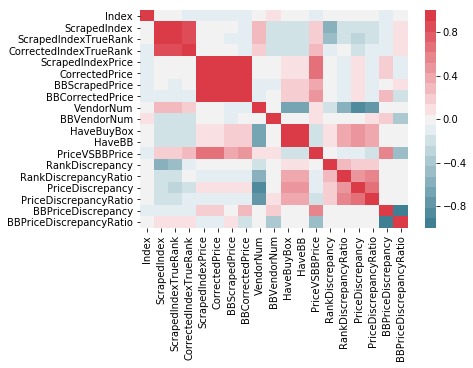

In [10]:
ax = sns.heatmap(
    dataframe.corr(),
    vmin=-1, vmax=1, # Make the scale span -1 to 1
    cmap=sns.diverging_palette(220, 10, n=21), # Use a diverging blue-red scale with 21 levels
)


In [11]:

"""
Rank Discrenpancy = Corrected Rank (Rank by actual total cost: 5th) - Scraped Rank (On Amazon: 1st) = 4
Positive value reflects how much higher that the item has been ranked than it should has been.
-Most of the amazon vendor items had been ranked higher (within the range from 34th higher to 1th lower) than the ranking shown on the internet
-Majority of the FBA vendor items had been ranked higher (within the range from 34th higher to 23th lower) than the ranking shown on the internet
Negative value reflects how much lower that the item has been ranked than it should has been.
-Majority of the Other vendor items had been ranked lower (within the range from 13th higher to 106th lower) than the ranking shown on the internet.
"""
dataframe.RankDiscrepancy.groupby(dataframe.ScrapedIndexVendorType).describe()

,count,mean,std,min,25%,50%,75%,max
ScrapedIndexVendorType,,,,,,,,
Amazon,192.0,5.104167,6.611871,-10.0,1.0,3.0,7.0,34.0
FBA,409.0,5.112469,7.616871,-23.0,0.0,3.0,9.0,34.0
Other,6372.0,-4.293001,12.083942,-155.0,-3.0,-1.0,0.0,9.0


Number of Products that had been ranked higher (Ratio):
Amazon:  149  / 192 =  0.78
FBA:  254  / 409 =  0.62
Other:  260  / 6372 =  0.04


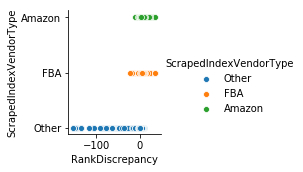

In [12]:
#RankDiscrepancy = Scraped Index True Rank (Actual Ranking based on the corrected price) - Scraped Index Rank
#Most product has been ranked to a higher 
sns.pairplot(dataframe,y_vars=["ScrapedIndexVendorType"], x_vars=["RankDiscrepancy"], hue="ScrapedIndexVendorType")

print('Number of Products that had been ranked higher (Ratio):')
print('Amazon: ', dataframe.Index[(dataframe.RankDiscrepancy > 0) & (dataframe.VendorNum == 0)].count(), " / 192 = ", round(149/192, 2))
print('FBA: ', dataframe.Index[(dataframe.RankDiscrepancy > 1) & (dataframe.VendorNum == 1)].count(), " / 409 = ", round(254/409, 2))
print('Other: ', dataframe.Index[(dataframe.RankDiscrepancy > 2) & (dataframe.VendorNum == 2)].count(), " / 6372 = ", round(260/6372, 2))

Number of Products that had been priced lower (Ratio):
Amazon:  190  / 192 =  0.99
FBA:  347  / 409 =  0.85
Other:  5777  / 6372 =  0.91


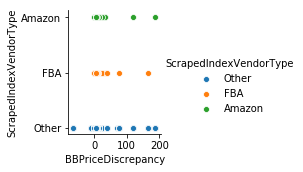

In [13]:
print('Number of Products that had been priced lower (Ratio):')
print('Amazon: ', dataframe.Index[(dataframe.BBPriceDiscrepancy > 0) & (dataframe.VendorNum == 0)].count(), " / 192 = ", round(190/192, 2))
print('FBA: ', dataframe.Index[(dataframe.BBPriceDiscrepancy > 1) & (dataframe.VendorNum == 1)].count(), " / 409 = ", round(347/409, 2))
print('Other: ', dataframe.Index[(dataframe.BBPriceDiscrepancy > 2) & (dataframe.VendorNum == 2)].count(), " / 6372 = ", round(5777/6372, 2))

sns.pairplot(dataframe, y_vars=["ScrapedIndexVendorType"], x_vars=["BBPriceDiscrepancy"], hue="ScrapedIndexVendorType")

Logistic Regression

In [14]:
#Logistic Regression to predict a single categorical response
# Make a scatter plot comparing `al` and `household`
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()

feature_cols=['ScrapedIndex', 'ScrapedIndexTrueRank', 'CorrectedIndexTrueRank', 'ScrapedIndexPrice',
       'CorrectedPrice', 'BBScrapedPrice', 'BBCorrectedPrice',
       'VendorNum', 'BBVendorNum']

X = dataframe.loc[:,feature_cols]
y = dataframe.loc[:, 'HaveBB']

In [15]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3,random_state = 8)

logreg.fit(X_train, y_train)

y_pred_test = logreg.predict(X_test)
y_pred_train = logreg.predict(X_train)

print('Train MSE:', metrics.mean_squared_error(y_train, y_pred_train))
print('Test MSE:', metrics.mean_squared_error(y_test, y_pred_test))
print('Train Accuracy Score', logreg.score(X_train, y_train))
print('Test Accuracy Score', logreg.score(X_test, y_test))

Train MSE: 0.019258348699037083
Test MSE: 0.01959847036328872
Train Accuracy Score 0.9807416513009629
Test Accuracy Score 0.9804015296367112


The accuracy scores reflects that the performance of the lorgistic regression model is really good. Since the gap between the train and test set is small, we don't have bias or variance issue with this model.

Then, I use K-fold cross-validation

In [16]:
#K-fold cross-validation is slower than a simple train/test split, but it gives more reliable estimates of generalization error. Use ten-fold cross-validation to evaluate your model's MSE on both training and test data. Use this result to answer the following questions.
from sklearn.model_selection import KFold

kf = KFold(n_splits=10, shuffle=True)

train_mse_values = []
test_mse_values = []

for train_indices, test_indices in kf.split(X, y):
    
    X_train = X.iloc[train_indices, :]
    y_train = y.iloc[train_indices]
    X_test = X.iloc[test_indices, :]
    y_test = y.iloc[test_indices]
    
    logreg.fit(X_train, y_train)
    y_pred_train = logreg.predict(X_train)
    y_pred_test = logreg.predict(X_test)
    
    
    train_mse = metrics.mean_squared_error(y_train, y_pred_train)
    test_mse = metrics.mean_squared_error(y_test, y_pred_test)
    
    train_mse_values.append(train_mse)
    test_mse_values.append(test_mse)

print('Average train MSE', sum(train_mse_values)/10)
print('Average test MSE', sum(test_mse_values)/10)



Average train MSE 0.020061500333909736
Average test MSE 0.020507044106341955


K Nearet Neighbors

In [23]:

from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier(n_neighbors = 13)
knn.fit(X_train, y_train)
y_pred_class_train = knn.predict(X_train)
y_pred_class_test = knn.predict(X_test)
    
print('Train set accuracy score: ', metrics.accuracy_score(y_train, y_pred_class_train))
print('Test set accuracy score: ', metrics.accuracy_score(y_test, y_pred_class_test))

Train set accuracy score:  0.9759400892288081
Test set accuracy score:  0.9799139167862266


In [17]:
from sklearn.neighbors import KNeighborsClassifier

train_scores = []
test_scores = []

#trying k's 1-20
for k in range(1,20):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    
    train_preds_class = knn.predict(X_train)
    test_preds_class = knn.predict(X_test)
    
    train_accuracy_class = metrics.accuracy_score(y_train, train_preds_class)
    test_accuracy_class = metrics.accuracy_score(y_test, test_preds_class)
    
    train_scores.append(train_accuracy_class)
    test_scores.append(test_accuracy_class)

In [18]:
# Store k and associated training scores in a DataFrame
scores_df = pd.DataFrame({'k':range(1,20), 'train_scores': train_scores, 'test_scores': test_scores})
scores_df.head(20)

,k,train_scores,test_scores
0,1,1.000000,0.975610
1,2,0.989802,0.977044
2,3,0.989324,0.978479
3,4,0.985182,0.979914
4,5,0.984544,0.977044
5,6,0.980242,0.978479
6,7,0.980561,0.979914
7,8,0.978489,0.979914
8,9,0.979286,0.979914
9,10,0.978649,0.978479


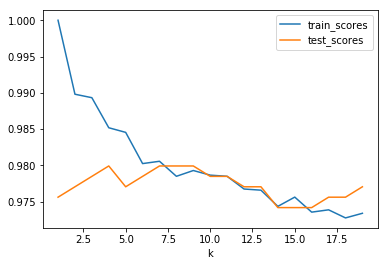

In [19]:
#Plot the training and testing scores against k
ax = scores_df.plot(x='k')

In [20]:
#max_features=7 is best
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier(n_neighbors = 7)
knn.fit(X_train, y_train)
y_pred_class_train = knn.predict(X_train)
y_pred_class_test = knn.predict(X_test)
    
print('Train set accuracy score: ', metrics.accuracy_score(y_train, y_pred_class_train))
print('Test set accuracy score: ', metrics.accuracy_score(y_test, y_pred_class_test))

Train set accuracy score:  0.9805608667941363
Test set accuracy score:  0.9799139167862266


The accuracy score still pretty good. Since the the difference between the train and test set is larger than the Lorgistic Regression one, it probably has more bias issue than the Lorgistic Regression model.??

Random Forest Regressor

In [21]:
from sklearn.ensemble import RandomForestRegressor

# max_features=3 is best and n_estimators=150 is sufficiently large.
rfreg = RandomForestRegressor(n_estimators=150, max_features=3, oob_score=True, random_state=1)
rfreg.fit(X, y)

C:\Users\Liszt\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=3, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=150, n_jobs=1, oob_score=True, random_state=1,
           verbose=0, warm_start=False)

In [22]:
# Compute feature importances.
pd.DataFrame({'feature':feature_cols, 'importance':rfreg.feature_importances_}).sort_values(by='importance')

,feature,importance
8,BBVendorNum,0.033828
6,BBCorrectedPrice,0.063196
3,ScrapedIndexPrice,0.065878
4,CorrectedPrice,0.068658
5,BBScrapedPrice,0.074193
2,CorrectedIndexTrueRank,0.078641
0,ScrapedIndex,0.114299
1,ScrapedIndexTrueRank,0.157870
7,VendorNum,0.343437


In [23]:
# Compute the out-of-bag R-squared score.
print((rfreg.oob_score_))

# Find the average RMSE.
from sklearn.model_selection import cross_val_score
scores = cross_val_score(rfreg, X, y, cv=10, scoring='neg_mean_squared_error')
np.mean(np.sqrt(-scores))

0.8076368019585946


0.1085429521511759

Decision Tree Classifier

In [24]:
max_depth_range = list(range(1, 21))

In [25]:
# Use 10-fold cross-validation with each value of max_depth.
RMSE_scores = []

from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
for depth in max_depth_range:
    treereg = DecisionTreeRegressor(max_depth=depth, random_state=1)
    MSE_scores = cross_val_score(treereg, X, y, cv=10, scoring='neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

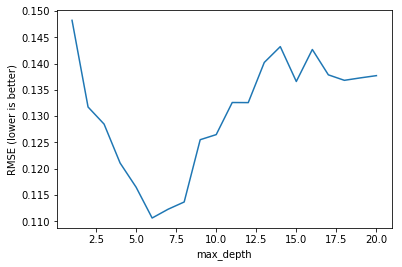

In [26]:
# Find out the best max_depth
fig, ax = plt.subplots()
ax.plot(max_depth_range, RMSE_scores);
ax.set_xlabel('max_depth');
ax.set_ylabel('RMSE (lower is better)');


In [27]:
sorted(zip(RMSE_scores, max_depth_range))[0]

(0.11062570378712884, 6)

In [28]:
# max_depth=6 was best, so fit a tree using that parameter.
treereg = DecisionTreeRegressor(max_depth=6, random_state=1)
treereg.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=6, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=1, splitter='best')

In [29]:
y_pred_tree_train = knn.predict(X_train)
y_pred_tree_test = knn.predict(X_test)
    
print('Train set accuracy score: ', metrics.accuracy_score(y_train, y_pred_tree_train))
print('Test set accuracy score: ', metrics.accuracy_score(y_test, y_pred_tree_test))

Train set accuracy score:  0.9805608667941363
Test set accuracy score:  0.9799139167862266


In [30]:
# Compute feature importances.
pd.DataFrame({'feature':feature_cols, 'importance':treereg.feature_importances_}).sort_values(by='importance')

,feature,importance
4,CorrectedPrice,0.007093
2,CorrectedIndexTrueRank,0.009125
6,BBCorrectedPrice,0.010269
3,ScrapedIndexPrice,0.012762
8,BBVendorNum,0.052566
5,BBScrapedPrice,0.055509
0,ScrapedIndex,0.080012
1,ScrapedIndexTrueRank,0.167252
7,VendorNum,0.605412


Summary: The best model is Logistic Regression because if has the higher accuracy score than the other models.
    